### This notebook has the training colormap plots that show spectral information

8/21

Imports

In [186]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os
from datetime import datetime
import argparse
import torch.nn.functional as F

Set save to True if you want to save plots

In [187]:
save = True

Only for python script: uncomment if running on cluster

In [188]:
# These are both placeholders
num_epochs = 1000
model_name = 'f0'

In [189]:
# # Parse command-line arguments
# parser = argparse.ArgumentParser(description='Train a neural network model')
# parser.add_argument('--epochs', type=int, default=1000, help='Number of training epochs')
# parser.add_argument('--model_name', type=str, default='model', help='Name of the saved model')
# args = parser.parse_args()

# # Use the parsed arguments
# num_epochs = args.epochs
# model_name = args.model_name

Check if CUDA is available

In [190]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [191]:
# For reproducibility
seed = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

**Simplified function generation**

In [192]:
def generate_freq_dataset(num_samples, num_points, min_freq, max_freq):
    x = torch.linspace(0, 2 * np.pi, num_points, requires_grad=True)
    functions = []
    derivatives = []
    
    for _ in range(num_samples):
        # The number of different frequency components will be between 1 and 10
        num_freqs = torch.randint(1, 10, (1,)).item()
        amplitudes = torch.rand(num_freqs * 2)  # Double the number of amplitudes (between 0 and 1)
        frequencies = torch.randint(min_freq, max_freq + 1, (num_freqs,)).float()
        phases = torch.rand(num_freqs * 2) * 2 * np.pi  # Double the number of phases
        
        y = sum(a * torch.sin(f * x + p) for a, f, p in zip(amplitudes[:num_freqs], frequencies, phases[:num_freqs])) + \
            sum(a * torch.cos(f * x + p) for a, f, p in zip(amplitudes[num_freqs:], frequencies, phases[num_freqs:]))
        
        dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
        
        functions.append(y.detach().numpy())
        derivatives.append(dy_dx.detach().numpy())
    
    return np.array(functions), np.array(derivatives)

## Generate datasets

In [193]:
num_samples = 500
num_points = 1000
batch_size = 32

low_freq_functions, low_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 5)
general_freq_functions, general_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 10)
high_freq_functions, high_freq_derivatives = generate_freq_dataset(num_samples, num_points, 6, 10)

low_freq_dataset = TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives))
general_freq_dataset = TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives))
high_freq_dataset = TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives))

low_freq_dataloader = DataLoader(TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives)), batch_size=batch_size, shuffle=True)
high_freq_dataloader = DataLoader(TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives)), batch_size=batch_size, shuffle=True)
general_freq_dataloader = DataLoader(TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives)), batch_size=batch_size, shuffle=True)

In [194]:
total_size = len(low_freq_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)

# low freq
train_dataset_l, test_dataset_l = random_split(low_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_l = DataLoader(train_dataset_l, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_l = DataLoader(test_dataset_l, batch_size=32, shuffle=False, drop_last=True)

# general freq
train_dataset_g, test_dataset_g = random_split(general_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_g = DataLoader(train_dataset_g, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_g = DataLoader(test_dataset_g, batch_size=32, shuffle=False, drop_last=True)

# high freq
train_dataset_h, test_dataset_h = random_split(high_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_h = DataLoader(train_dataset_h, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_h = DataLoader(test_dataset_h, batch_size=32, shuffle=False, drop_last=True)


## Plot random function from one of the datasets

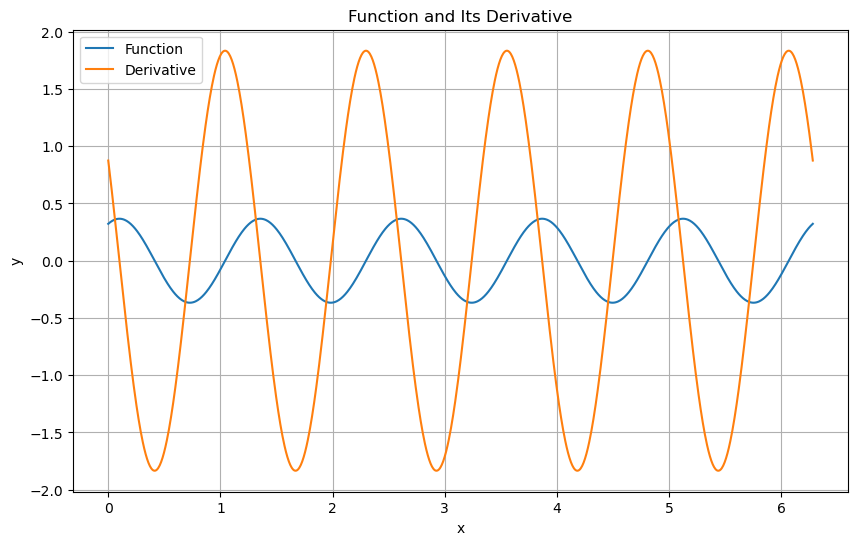

In [195]:
a = np.random.randint(32)

fun, deriv = next(iter(low_freq_dataloader))

first_function = fun[a]
first_derivative = deriv[a]

# Generate x values corresponding to the function inputs
x_values = np.linspace(0, 2 * np.pi, 1000)

# Plotting the function and its derivative
plt.figure(figsize=(10, 6))
plt.plot(x_values, first_function, label='Function')
plt.plot(x_values, first_derivative, label='Derivative')
plt.title('Function and Its Derivative')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [196]:
# Save datasets
# torch.save(general_freq_dataset, 'datasets/general_freq_dataset.pt')
# torch.save(low_freq_dataset, 'datasets/low_freq_dataset.pt')
# torch.save(high_freq_dataset, 'datasets/high_freq_dataset.pt')

Stopped here

## Model architecture

This CNN uses 3 layers, each with kernel size 3

In [197]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [198]:
f0 = SimpleCNN()
criterion = nn.MSELoss()

## Miscellaneous plotting functions

In [199]:
def plot_losses(train_losses, test_losses, save_dir='plots', filename=None, save=False):
    if not train_losses:
        return
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    current_date = datetime.now().strftime("%m-%d")
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"
    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)    
    plt.show()

In [200]:
def plot_output(model1, dataset, order=None, save_dir='plots', filename=None, save=False): 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    current_date = datetime.now().strftime("%m-%d")
    model1.eval()  # Set the model to evaluation mode

    train_dataloader_viz = get_random_function(dataset, shuffle=True)
    # Get a random sample from the dataloader
    dataiter = iter(train_dataloader_viz)
    function, true_derivative = next(dataiter)

    # Reshape the input for the model
    function = function.unsqueeze(1)  # Add channel dimension

    # Make prediction
    with torch.no_grad():
        if order == 1 or order == 2:
            predicted_derivative = model1(function)
        
        if order == 'rollout':
            predicted_derivative = model1(function)
            predicted_derivative = model1(predicted_derivative)

    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()
    function = function.squeeze().numpy()

    predicted_derivative = predicted_derivative.squeeze().numpy()

    true_derivative = true_derivative.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.plot(x, function, label='Original Function', color='blue')
    if order == 1:
        plt.plot(x, true_derivative, label=f'True {order}st derivative')

    plt.plot(x[10:-10], predicted_derivative[10:-10], label=f'Predicted {order}nd Derivative', linestyle='--')

    plt.title('Function, True Derivatives, and Predicted Derivatives')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"

    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

In [201]:
def get_random_function(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=1, shuffle=shuffle)

## Create models

In [202]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self, n_layers=3, kernel_size=3, hidden_size=64):
        super(SimpleCNN, self).__init__()
        # Parameters
        self.n_layers = n_layers
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size

        # Model
        self.convs = nn.ModuleList()
        if n_layers == 1:
            self.convs.append(nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size//2))
        elif n_layers >= 2:
            self.convs.append(nn.Conv1d(1, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            for _ in range(n_layers - 2):
                self.convs.append(nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            self.convs.append(nn.Conv1d(hidden_size, 1, kernel_size=kernel_size, padding=kernel_size//2))
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        for i, conv in enumerate(self.convs):
            if i < len(self.convs) - 1:
                x = self.relu(conv(x))
            else:
                x = conv(x)
        return x

## Tests to see model output frequencies

In [203]:
def plot_frequencies(function, derivative=None, residue=None, model=None):
    x = np.linspace(0, 2*np.pi, 1000)
    first_function = function

    N = 1000

    # frequencies = torch.fft.fftfreq(N, 2*np.pi/N) * 2*np.pi
    frequencies = np.fft.fftfreq(N, 1/N)
    positive_freq_indices = frequencies >= 0
    positive_freqs = frequencies[positive_freq_indices]

    F = np.fft.fft(first_function.detach().numpy())
    magnitudes = np.abs(F) / N
    positive_magnitudes = magnitudes[positive_freq_indices]

    if residue:
        model.eval()
        F_derivative = np.fft.fft(derivative.detach().numpy())
        F_output = np.fft.fft(model(function.unsqueeze(0)).squeeze().detach().numpy())

        F_residue = F_derivative - F_output
        magnitudes = np.abs(F_residue) / N
        print("residue")


    # Plotting the frequency spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(positive_freqs, positive_magnitudes, label='Function')
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.title('Frequency Spectrum of the Function')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 20)  # Adjust this based on your frequency range
    print(f"lim: 18")
    plt.show()


lim: 18


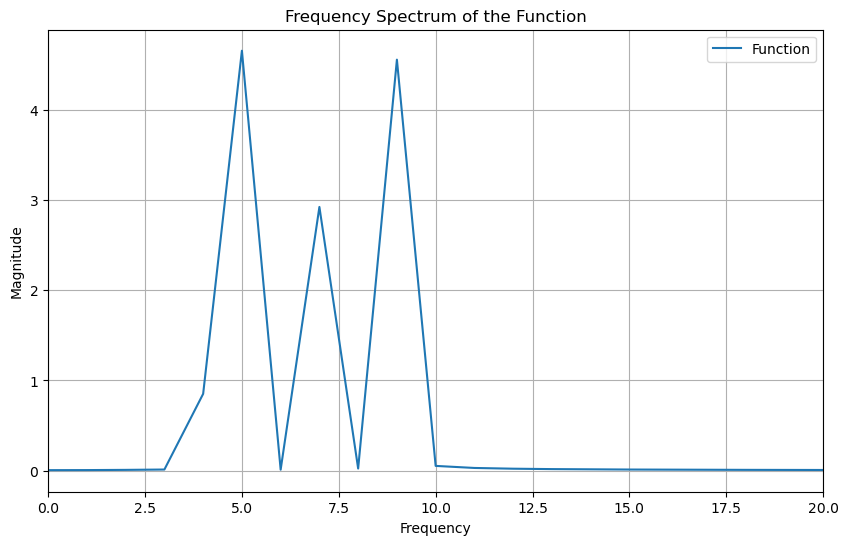

In [204]:
a = np.random.randint(0, 32)
function = test_dataset_g[a][0]
derivative = test_dataset_g[a][1]

plot_frequencies(derivative)

In [205]:
set_seed(seed)
L3ModelK3 = SimpleCNN(n_layers=3, kernel_size=3)
L3ModelK3.load_state_dict(torch.load('../../models/3_layers.pth'))

L3ModelK3_untrained = SimpleCNN(n_layers=3, kernel_size=3)

lim: 18


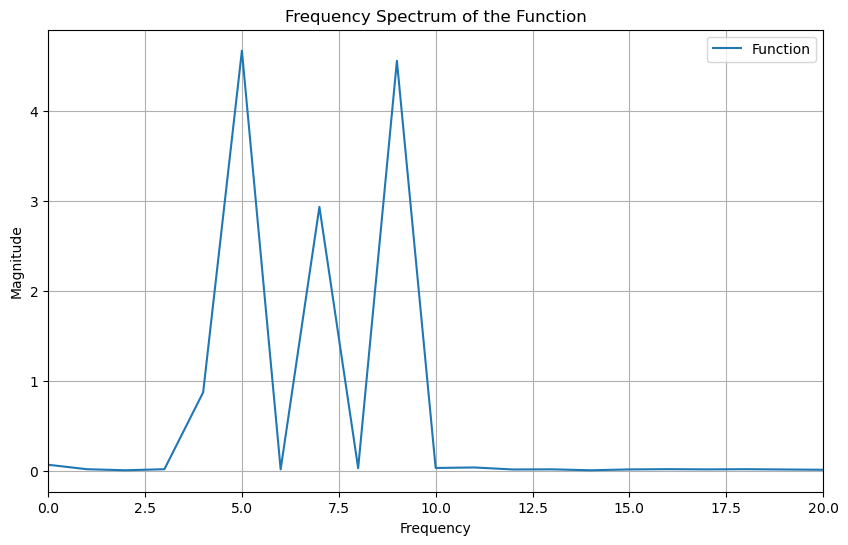

In [206]:
function1 = function.unsqueeze(0)
output = L3ModelK3(function1).squeeze()
plot_frequencies(output)

residue
lim: 18


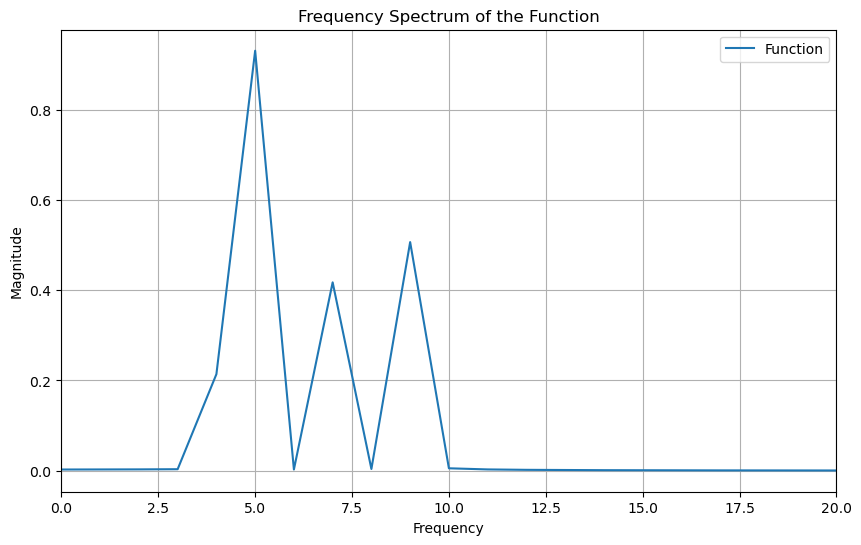

In [207]:
plot_frequencies(function=function, derivative=derivative, residue=True, model=L3ModelK3)

lim: 18


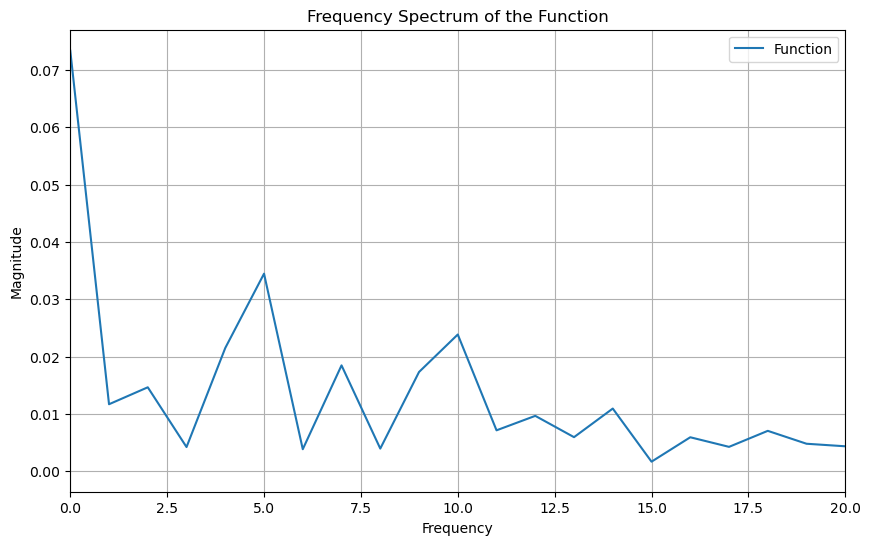

In [208]:
# This is incorrect, since we want fourier(deriv) - fourier(output) not deriv - output
plot_frequencies(derivative - output)

## Metric functions

In [209]:
def compute_mse(dataloader, model):
    """
    Takes in a dataloader and a model to compute MSE.
    """

    model.eval()
    all_outputs = []
    all_targets = []

    for function, deriv in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)

        # Compute model output
        model_output = model(function)
        all_targets.append(deriv)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_targets - all_outputs) ** 2)
    nmse = mse / torch.mean(all_targets ** 2)

    return mse.item(), nmse.item()

In [210]:
def print_and_store_metrics(f0):
    return compute_mse(train_dataloader_l, f0)[1], compute_mse(train_dataloader_g, f0)[1], compute_mse(train_dataloader_h, f0)[1]

In [211]:
def print_metrics(model):
    print(f"NMSE over low freq test functions: {compute_mse(test_dataloader_l, model)[1]}")
    print(f"NMSE over general freq test functions: {compute_mse(test_dataloader_g, model)[1]}")
    print(f"NMSE over high freq test functions: {compute_mse(test_dataloader_h, model)[1]}")



## Plot results

In [212]:
def plot_all_outputs(model, model_name):
    plot_output(model, dataset=test_dataset_l, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    plot_output(model, dataset=test_dataset_g, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    plot_output(model, dataset=test_dataset_h, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)

## Color map plots

In [213]:
# RMS norm function
def RMS(tensor):
    # Calculate the square of each element
    squared = tensor ** 2
    
    # Sum the squares along each row (dimension 1)
    sum_of_squares = torch.sum(squared, dim=1)
    
    # Divide by the number of elements in each row (N)
    mean_of_squares = sum_of_squares / tensor.shape[1]
    
    # Take the square root of the mean
    norms = torch.sqrt(mean_of_squares)
    
    return norms

In [214]:
def compute_fft_and_max_freq(dataloader, deriv=False, model=None, residue=False):
    fft_amplitudes = []
    max_frequencies = []
    T = 2 * torch.pi
    N = 1000

    # The spacing is T / N, i.e. 2pi/1000, but since we interpret f(x)=sin(5x) to
    # have a frequency of 5 over the domain x=[0,2pi], then we scale up by 2pi 
    # to get the unit cycle back to 1
    frequencies = torch.fft.fftfreq(N, T / N) * T
    positive_freq_indices = frequencies >= 0
    positive_freqs = frequencies[positive_freq_indices]

    plot_type = ''

    # Iterate over each batch
    for functions, derivatives in dataloader:  # Note that derivatives are ignored in this loop
        
        if deriv and not model and not residue: # If you only want the derivative
            functions = derivatives
            F = torch.fft.fft(functions)
            plot_type = "ground truth u_g'"
            
            
        elif not deriv and model and not residue: # If you only want the model output
            functions = model(functions.unsqueeze(1)).squeeze()
            F = torch.fft.fft(functions)
            plot_type = 'model output f(u_g)'

            # output = model(functions)
            
            # output = output.squeeze()
            # functions = output # set this so that the FFTs can be computed in the next line
        
        elif residue == 'error of fourier' and model: # If you only want the spectral error
            
            functions = functions.unsqueeze(1)
            outputs = model(functions).squeeze()
            F_outputs = torch.fft.fft(outputs)

            F_derivatives = torch.fft.fft(derivatives)

            residues = F_derivatives - F_outputs

            print(f"shape of residues: {residues.shape}")
            print(f"shape of RMS: {F_derivatives.shape}, {RMS(F_derivatives).unsqueeze(1).shape}")
            residues = residues / RMS(F_derivatives).unsqueeze(1)
            
            # normalizing = F_derivatives.norm(p=2, dim=1, keepdim=True) ** 2 / F_derivatives.shape[1]
            # print(f"shape of normalizing: {normalizing}")
            # residues = residues / normalizing

            F = residues
            plot_type = 'spectral error'
        
        elif residue == 'fourier of error' and model:
            functions = functions.unsqueeze(1)
            outputs = model(functions).squeeze()

            residues = derivatives - outputs
            F = torch.fft.fft(residues)
            plot_type = 'fourier transform of error'

        else:
            plot_type = 'ground truth u_g'
            F = torch.fft.fft(functions)

        # else: # If you only want the original function u_g
        magnitudes = torch.abs(F) / N

        # Consider only positive frequencies
        positive_magnitudes = magnitudes[:, positive_freq_indices]

        fft_amplitudes.append(positive_magnitudes)
        
        # Maximum frequency based on the highest amplitude for each function in the batch
        max_indices = torch.argmax(positive_magnitudes, dim=1)
        batch_max_freqs = positive_freqs[max_indices]
        max_frequencies.extend(batch_max_freqs)
        print(f"Plotting {plot_type}")

    return torch.vstack(fft_amplitudes), torch.tensor(max_frequencies), positive_freqs, plot_type

def plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type, xmin=0, xmax=0,\
    first=False, sorted_indices=None):

    fft_amplitudes = fft_amplitudes.detach().numpy()
    max_frequencies = max_frequencies.detach().numpy()
    freqs = freqs.detach().numpy()

    
    if first:
        print("Sorting u_g for the first time")
        # Sort functions by dominant frequency in descending order
        sorted_indices = np.argsort(-max_frequencies) 
        sorted_fft = fft_amplitudes[sorted_indices]
    else:
        print("Using predefined sort")
        sorted_fft = fft_amplitudes[sorted_indices]

    plt.figure(figsize=(10, 6))
    im = plt.imshow(sorted_fft, aspect='auto', extent=[freqs[0], freqs[-1], 0, len(sorted_fft)],\
        interpolation='nearest')

    plt.colorbar(im, label='Amplitude')
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('Function Index (sorted by max frequency)')
    plt.title(f'FFT Amplitude Heatmap for {fun_type}')
    plt.xlim([xmin, xmax])
    

    if first:
        return sorted_indices

    plt.show()


In [215]:
def plot_combined_heatmap(fft_amplitudes1, max_frequencies1, freqs1, fun_type1,\
    fft_amplitudes2, max_frequencies2, freqs2, fun_type2,\
    xmin=0, xmax=0, first=False, sorted_indices=None):

    fft_amplitudes1 = fft_amplitudes1.detach().numpy()
    max_frequencies1 = max_frequencies1.detach().numpy()
    freqs1 = freqs1.detach().numpy()

    fft_amplitudes2 = fft_amplitudes2.detach().numpy()
    max_frequencies2 = max_frequencies2.detach().numpy()
    freqs2 = freqs2.detach().numpy()

    
    if first:
        print("Sorting u_g for the first time")
        # Sort functions by dominant frequency in descending order
        sorted_indices1 = np.argsort(-max_frequencies1) 
        sorted_fft1 = fft_amplitudes1[sorted_indices]

        sorted_indices2 = np.argsort(-max_frequencies2) 
        sorted_fft2 = fft_amplitudes2[sorted_indices]
    else:
        print("Using predefined sort")
        sorted_fft1 = fft_amplitudes1[sorted_indices]
        sorted_fft2 = fft_amplitudes2[sorted_indices]

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot the first heatmap
    im1 = ax1.imshow(sorted_fft1, aspect='auto', extent=[freqs1[0], freqs1[-1], 0, len(sorted_fft1)],
                     interpolation='nearest')
    ax1.set_xlabel('Frequency (rad/s)')
    ax1.set_ylabel('Function Index (sorted by max frequency)')
    ax1.set_title(f'FFT Amplitude Heatmap for {fun_type1}')
    ax1.set_xlim([xmin, xmax])
    fig.colorbar(im1, ax=ax1, label='Amplitude')

    # Plot the second heatmap
    im2 = ax2.imshow(sorted_fft2, aspect='auto', extent=[freqs2[0], freqs2[-1], 0, len(sorted_fft2)],
                     interpolation='nearest')
    ax2.set_xlabel('Frequency (rad/s)')
    ax2.set_ylabel('Function Index (sorted by max frequency)')
    ax2.set_title(f'FFT Amplitude Heatmap for {fun_type2}')
    ax2.set_xlim([xmin, xmax])
    fig.colorbar(im2, ax=ax2, label='Amplitude')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    if first:
        return sorted_indices1

    plt.show()

In [216]:
# Default is u_g
# This function plots the heatmaps for all frequencies for the test datlaoaders
def plot_heatmaps(deriv=None, model=None, residue=False, label=None, all=True, epoch=None,\
    first=False, sorted_indices=None):
    if all: # Plot all three datasets
        fft_amplitudes, max_frequencies, freqs, label = compute_fft_and_max_freq(test_dataloader_l,\
            deriv=deriv, model=model, residue=residue)
        plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'Low freq {label} at epoch {epoch}',\
            xmin=0, xmax=6, sorted_indices=sorted_indices, first=first)

        fft_amplitudes, max_frequencies, freqs, label = compute_fft_and_max_freq(test_dataloader_g,\
            deriv=deriv, model=model, residue=residue)
        plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'General freq {label} at epoch {epoch}',\
            xmin=0, xmax=11, sorted_indices=sorted_indices, first=first)

        fft_amplitudes, max_frequencies, freqs, label = compute_fft_and_max_freq(test_dataloader_h,\
            deriv=deriv, model=model, residue=residue)
        plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'High freq {label} at epoch {epoch}',\
            xmin=6, xmax=11, sorted_indices=sorted_indices, first=first)

    else: # Plot only the general frequency dataset
        if model and residue:
            print("got the new amplitudes")
            # Get only the model outputs
            fft_amplitudes_model, max_frequencies_model, freqs_model, label_model = compute_fft_and_max_freq(test_dataloader_g,\
            deriv=deriv, model=model, residue=None)
            # Get only the residue
            fft_amplitudes_res, max_frequencies_res, freqs_res, label_res = compute_fft_and_max_freq(test_dataloader_g,\
            deriv=deriv, model=model, residue=residue)
        else: # If we don't want the model or residue plots, then use passed in settings
            fft_amplitudes, max_frequencies, freqs, label = compute_fft_and_max_freq(test_dataloader_g,\
            deriv=deriv, model=model, residue=residue)

        if first: # If first calculation, then need to only get the order of the original functions u_g
            fft_amplitudes, max_frequencies, freqs, label = compute_fft_and_max_freq(test_dataloader_g,\
            deriv=False, model=False, residue=False)

            return plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'General freq {label} at epoch {epoch}',\
            xmin=0, xmax=11, sorted_indices=sorted_indices, first=first)
        else:
            if model and residue:
                # plot_heatmap(fft_amplitudes_model, max_frequencies_model, freqs_model, fun_type=f'General freq {label_model} at epoch {epoch}',\
                # xmin=0, xmax=11, sorted_indices=sorted_indices, first=first)

                plot_combined_heatmap(fft_amplitudes1=fft_amplitudes_model, max_frequencies1=max_frequencies_model,\
                    freqs1=freqs_model, fun_type1=f'General freq {label_model} at epoch {epoch}',\
                    fft_amplitudes2=fft_amplitudes_res, max_frequencies2=max_frequencies_res,\
                    freqs2=freqs_res, fun_type2=f'General freq {label_res} at epoch {epoch}',\
                    xmin=0, xmax=11, sorted_indices=sorted_indices, first=first)

            else:
                plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'General freq {label} at epoch {epoch}',\
                xmin=0, xmax=11, sorted_indices=sorted_indices, first=first)


In [217]:
train_losses, test_losses = [], []

def model_training_plots(model, train_dataloader, test_dataloader, num_epochs,\
    split_freq=1, filename=None, save=None, order=None, nmse=False,\
        deriv=None, residue=None, lr=1e-3, heatmap=True):

    """
    model: provide a model to train
    train/test_dataloader: provide a specific dataloader 
    num_epochs: train for this many epochs
    split_freq: really should be called "number of colormaps to show"
    filename: filename to save final loss vs iterations plot as
    save: whether to save the file
    order: not sure this even matters
    nmse: set to True to use NMSE as loss function during training
    deriv: set to True to show derivative
    residue: set to 1 to show spectral error, i.e., hat(u_g') - hat(f(u_g)),
        and set to 2 to show fourier transform of error, i.e., hat(u_g' - f(u_g))
    


    """

    train_losses = []
    test_losses = []

    low_freq_nmses = []
    general_freq_nmses = []
    high_freq_nmses = []
    epoch_list = []

    lr = lr
    optimizer = optim.Adam(model.parameters(), lr=lr)

    criterion = nn.MSELoss()
    # If nmse, then use NMSE as loss
    if nmse:
        def criterion(target, output, nmse=None):
            mse = torch.mean((target - output) ** 2)
            mse = mse / torch.mean(target ** 2)
            
            return mse
    
    num_plots = split_freq
    split_freq = num_epochs // split_freq
    print(split_freq)

    # At the first epoch, compute the order of the functions before training
    sorted_indices = plot_heatmaps(label=f'first', all=False, first=True)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch_functions, batch_derivatives in train_dataloader:
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            outputs = model(batch_functions)
            loss = criterion(outputs, batch_derivatives)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)
                

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

        l, g, h = print_and_store_metrics(model)
        low_freq_nmses.append(l)
        general_freq_nmses.append(g)
        high_freq_nmses.append(h)
        epoch_list.append(epoch)

        # If iteration reached, then plot the colormap once
        # if heatmap:
        if (epoch) % split_freq == 0:
            print(f"Plotting the colormap once at iteration {epoch}")
            label = epoch // split_freq

            # First is false here, but we pass in
            plot_heatmaps(model=model, label=f'{label}', all=False,\
                deriv=deriv, residue=residue, epoch=epoch, sorted_indices=sorted_indices)

            if heatmap:
                plt.show()

    print(f"Training finished for {order}st derivative")

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, low_freq_nmses, label='Low freq NMSE')
    plt.plot(epoch_list, general_freq_nmses, label='General freq NMSE')
    plt.plot(epoch_list, high_freq_nmses, label='High freq NMSE')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.yscale('log')

    plt.title('NMSEs of different frequencies during training')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    if save:
        plt.savefig(filename)  

    return train_losses, test_losses, low_freq_nmses, general_freq_nmses, high_freq_nmses, epoch_list

got the new amplitudes
Plotting model output f(u_g)
Plotting model output f(u_g)
Plotting model output f(u_g)
shape of residues: torch.Size([32, 1000])
shape of RMS: torch.Size([32, 1000]), torch.Size([32, 1])
Plotting spectral error
shape of residues: torch.Size([32, 1000])
shape of RMS: torch.Size([32, 1000]), torch.Size([32, 1])
Plotting spectral error
shape of residues: torch.Size([32, 1000])
shape of RMS: torch.Size([32, 1000]), torch.Size([32, 1])
Plotting spectral error
Plotting ground truth u_g
Plotting ground truth u_g
Plotting ground truth u_g
Sorting u_g for the first time


array([ 1, 72, 69, 68, 66, 94, 45, 24, 15,  0, 93, 90, 83, 36, 95,  4,  9,
       12, 10, 11, 55, 92, 89, 81, 78, 51, 49, 43, 33, 31, 47, 16, 18, 13,
       65,  2, 27, 79, 41, 56, 86, 75,  8, 59, 57, 53, 48, 85, 73, 17, 34,
        6,  7, 38, 58, 40, 46, 19, 44, 50, 91, 71, 32, 87, 67, 28, 14, 30,
       62, 37, 88, 20,  5,  3, 63, 52, 64, 61, 42, 74, 25, 76, 77, 35, 60,
       84, 21, 26, 39, 70, 22, 54, 82, 80, 23, 29])

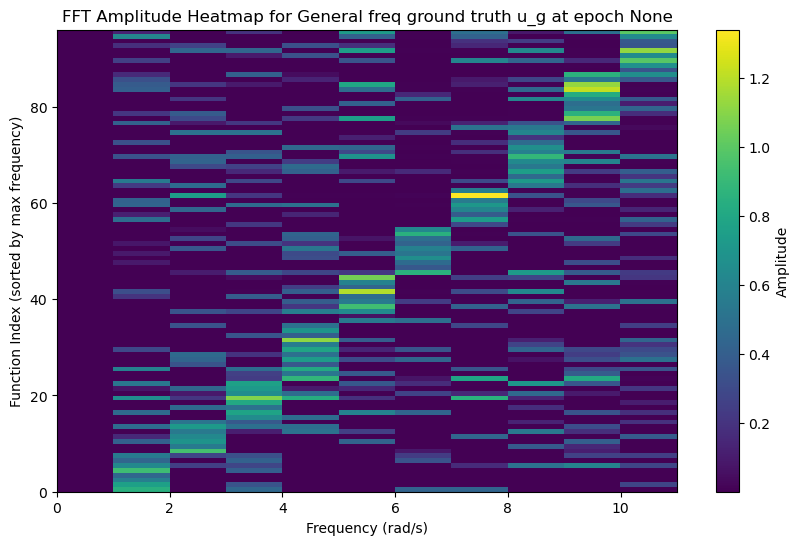

In [218]:
set_seed(seed)
L3ModelK3_low = SimpleCNN(n_layers=3, kernel_size=3)
plot_heatmaps(model=L3ModelK3_low, residue='error of fourier', all=False, first=True)


**The above looks a lot like the trained model output or true derivative**

50
Plotting ground truth u_g
Plotting ground truth u_g
Plotting ground truth u_g
Plotting ground truth u_g
Plotting ground truth u_g
Plotting ground truth u_g
Sorting u_g for the first time
Epoch [1/500], Train Loss: 67.1603, Test Loss: 73.1279
Plotting the colormap once at iteration 0
got the new amplitudes
Plotting model output f(u_g)
Plotting model output f(u_g)
Plotting model output f(u_g)
shape of residues: torch.Size([32, 1000])
shape of RMS: torch.Size([32, 1000]), torch.Size([32, 1])
Plotting spectral error
shape of residues: torch.Size([32, 1000])
shape of RMS: torch.Size([32, 1000]), torch.Size([32, 1])
Plotting spectral error
shape of residues: torch.Size([32, 1000])
shape of RMS: torch.Size([32, 1000]), torch.Size([32, 1])
Plotting spectral error
Using predefined sort


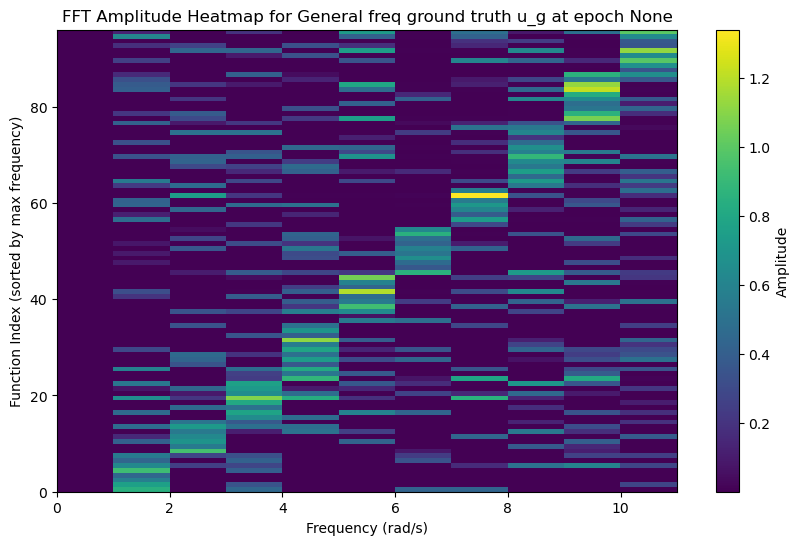

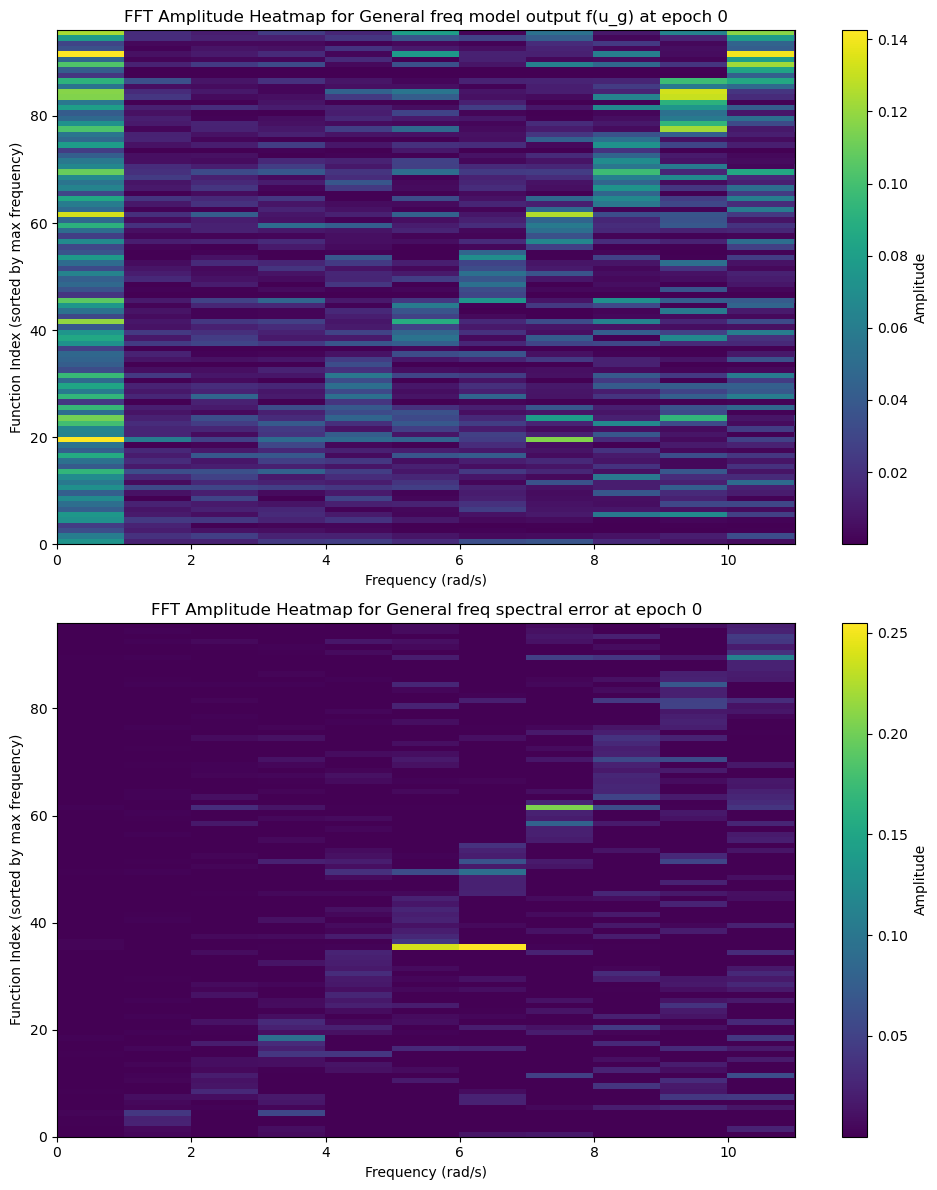

Epoch [2/500], Train Loss: 64.8199, Test Loss: 69.9443
Epoch [3/500], Train Loss: 62.2841, Test Loss: 64.2641
Epoch [4/500], Train Loss: 55.3626, Test Loss: 55.1882
Epoch [5/500], Train Loss: 45.5938, Test Loss: 42.6952
Epoch [6/500], Train Loss: 32.9114, Test Loss: 28.1286
Epoch [7/500], Train Loss: 19.6085, Test Loss: 14.6338
Epoch [8/500], Train Loss: 9.6330, Test Loss: 6.2754
Epoch [9/500], Train Loss: 4.6367, Test Loss: 4.0270
Epoch [10/500], Train Loss: 3.7964, Test Loss: 3.7737
Epoch [11/500], Train Loss: 3.6165, Test Loss: 3.5555
Epoch [12/500], Train Loss: 3.4017, Test Loss: 3.3747
Epoch [13/500], Train Loss: 3.2362, Test Loss: 3.2402
Epoch [14/500], Train Loss: 3.0249, Test Loss: 3.1100
Epoch [15/500], Train Loss: 2.9435, Test Loss: 2.9896
Epoch [16/500], Train Loss: 2.8642, Test Loss: 2.8697
Epoch [17/500], Train Loss: 2.7248, Test Loss: 2.7838
Epoch [18/500], Train Loss: 2.6249, Test Loss: 2.6347
Epoch [19/500], Train Loss: 2.5334, Test Loss: 2.5228
Epoch [20/500], Train Lo

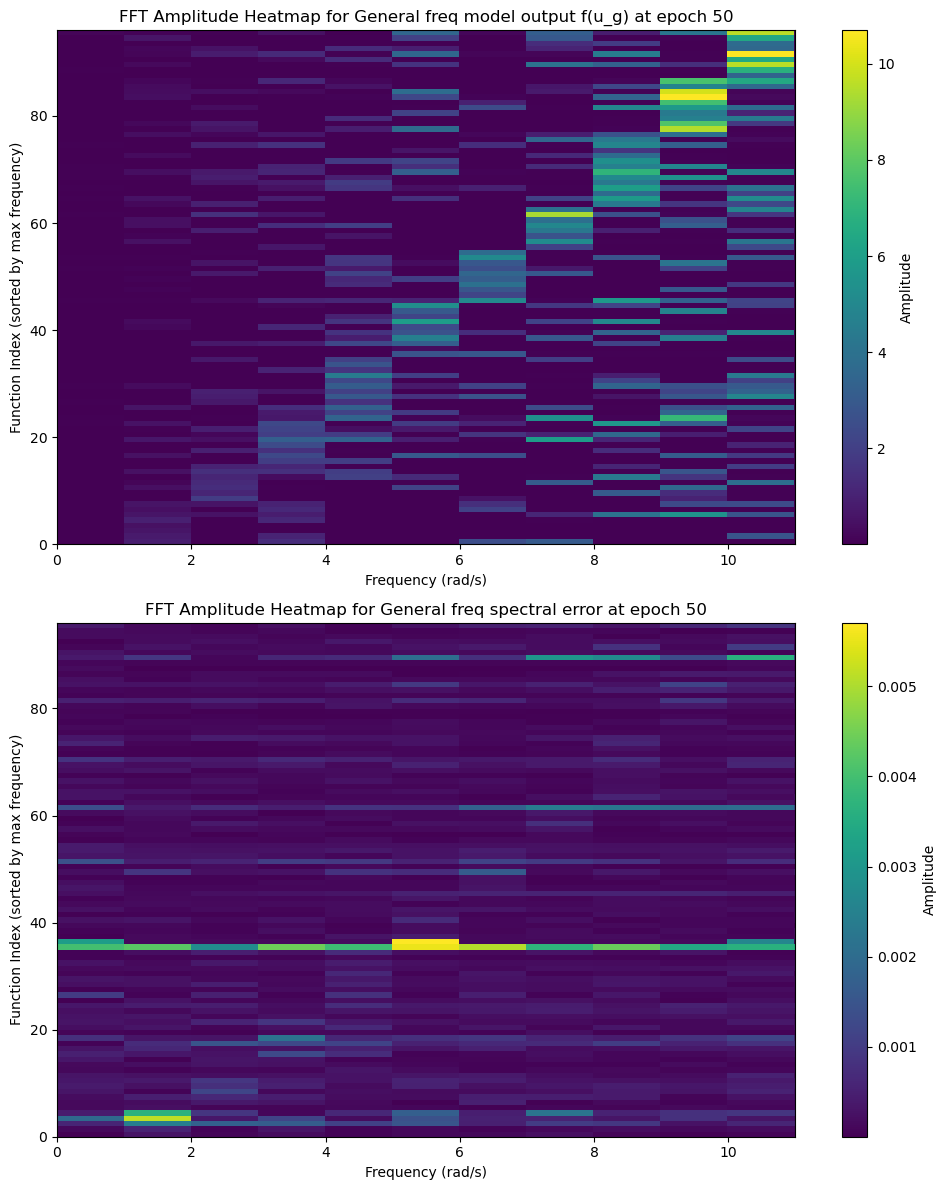

Epoch [52/500], Train Loss: 0.6098, Test Loss: 0.6362
Epoch [53/500], Train Loss: 0.5917, Test Loss: 0.6197
Epoch [54/500], Train Loss: 0.5939, Test Loss: 0.6836
Epoch [55/500], Train Loss: 0.5977, Test Loss: 0.5819
Epoch [56/500], Train Loss: 0.5519, Test Loss: 0.5802
Epoch [57/500], Train Loss: 0.5314, Test Loss: 0.5547
Epoch [58/500], Train Loss: 0.5084, Test Loss: 0.5889
Epoch [59/500], Train Loss: 0.5210, Test Loss: 0.5254
Epoch [60/500], Train Loss: 0.4854, Test Loss: 0.4995
Epoch [61/500], Train Loss: 0.4679, Test Loss: 0.4876
Epoch [62/500], Train Loss: 0.4673, Test Loss: 0.4790
Epoch [63/500], Train Loss: 0.4593, Test Loss: 0.5078
Epoch [64/500], Train Loss: 0.4523, Test Loss: 0.4629
Epoch [65/500], Train Loss: 0.4368, Test Loss: 0.4569
Epoch [66/500], Train Loss: 0.4351, Test Loss: 0.4399
Epoch [67/500], Train Loss: 0.4291, Test Loss: 0.4337
Epoch [68/500], Train Loss: 0.4026, Test Loss: 0.4208
Epoch [69/500], Train Loss: 0.3950, Test Loss: 0.4143
Epoch [70/500], Train Loss: 

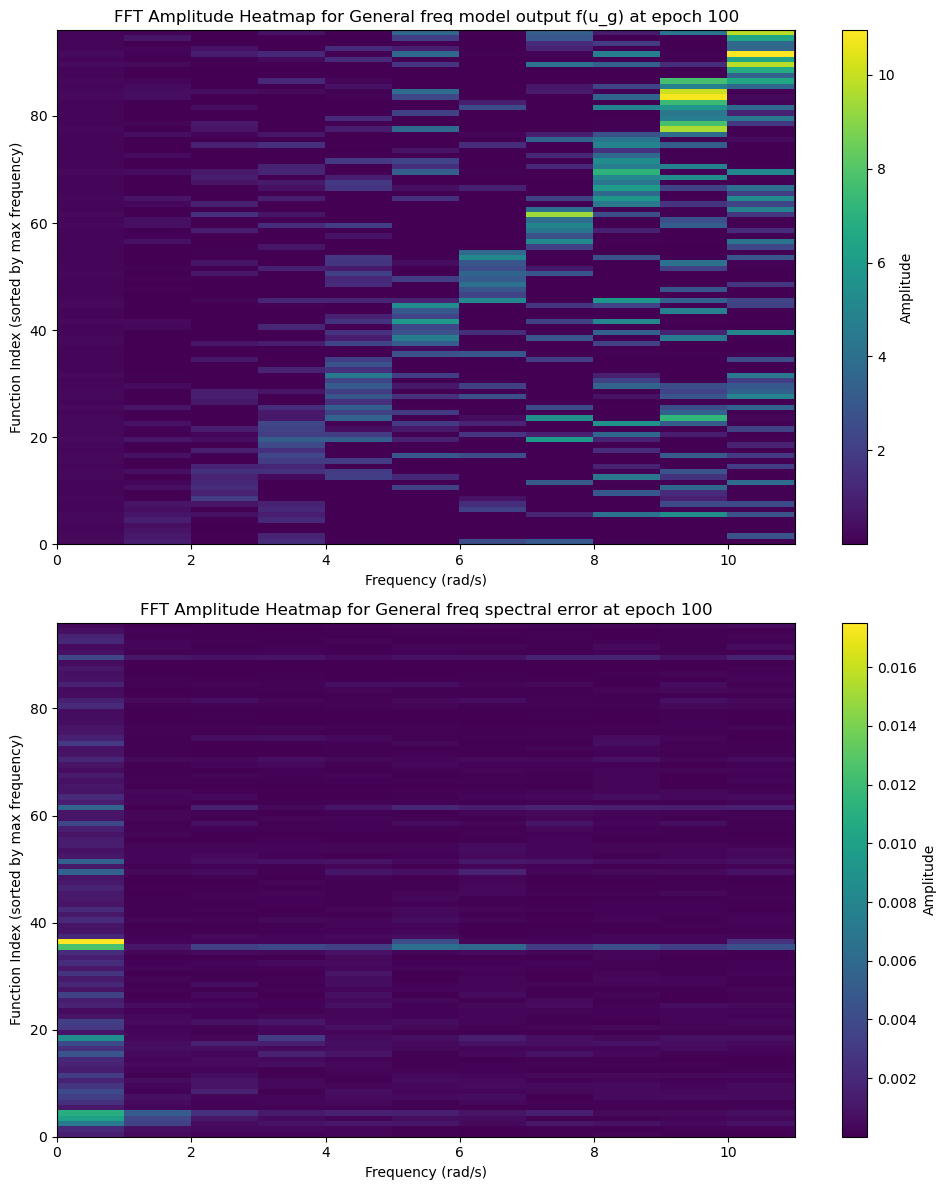

Epoch [102/500], Train Loss: 0.2933, Test Loss: 0.3287
Epoch [103/500], Train Loss: 0.3004, Test Loss: 0.2815
Epoch [104/500], Train Loss: 0.2706, Test Loss: 0.2782
Epoch [105/500], Train Loss: 0.2453, Test Loss: 0.2592
Epoch [106/500], Train Loss: 0.2330, Test Loss: 0.2510
Epoch [107/500], Train Loss: 0.2251, Test Loss: 0.2490
Epoch [108/500], Train Loss: 0.2256, Test Loss: 0.2454
Epoch [109/500], Train Loss: 0.2145, Test Loss: 0.2422
Epoch [110/500], Train Loss: 0.2206, Test Loss: 0.2505
Epoch [111/500], Train Loss: 0.2229, Test Loss: 0.2417
Epoch [112/500], Train Loss: 0.2153, Test Loss: 0.2376
Epoch [113/500], Train Loss: 0.2139, Test Loss: 0.2326
Epoch [114/500], Train Loss: 0.1990, Test Loss: 0.2306
Epoch [115/500], Train Loss: 0.2089, Test Loss: 0.2272
Epoch [116/500], Train Loss: 0.2037, Test Loss: 0.2265
Epoch [117/500], Train Loss: 0.2014, Test Loss: 0.2229
Epoch [118/500], Train Loss: 0.1995, Test Loss: 0.2228
Epoch [119/500], Train Loss: 0.2010, Test Loss: 0.2210
Epoch [120

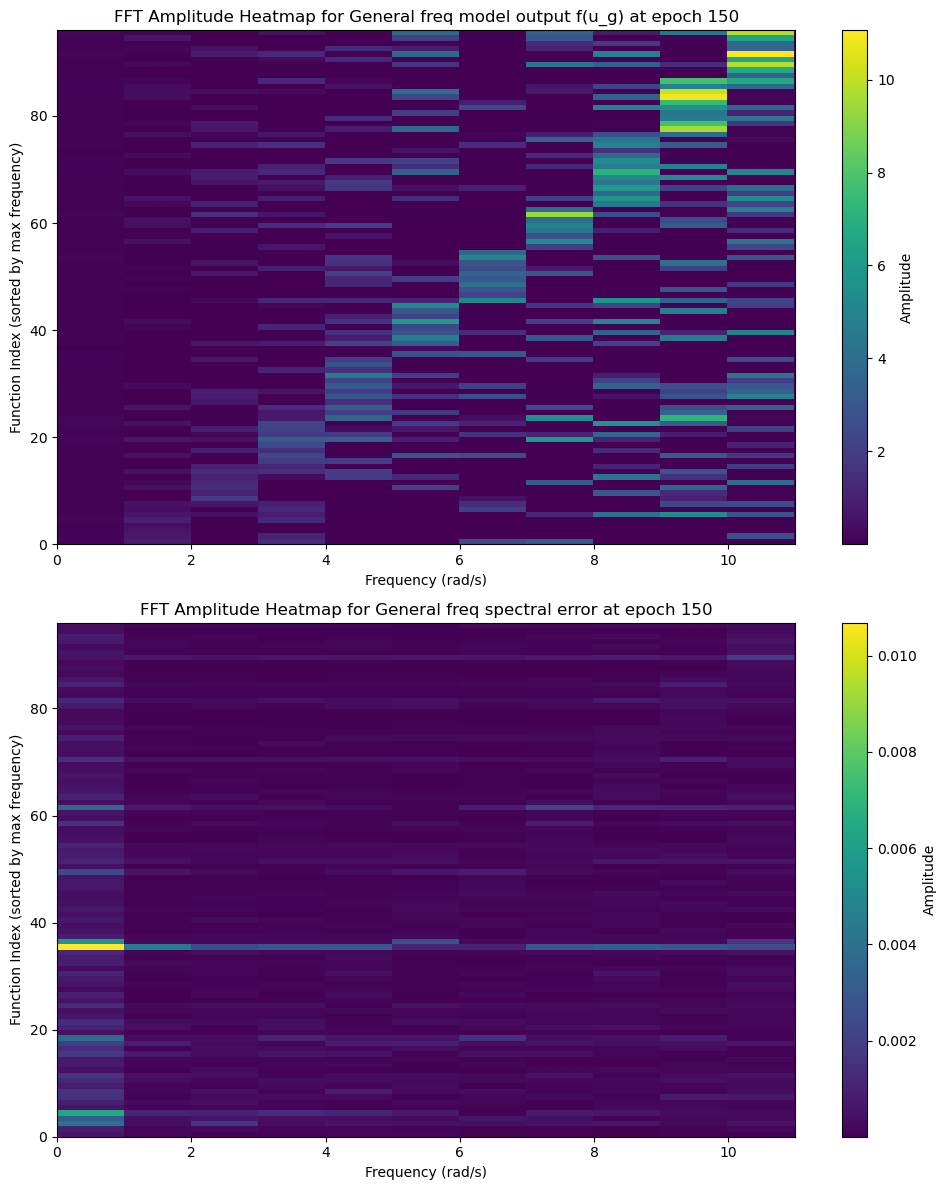

Epoch [152/500], Train Loss: 0.1692, Test Loss: 0.1759
Epoch [153/500], Train Loss: 0.1570, Test Loss: 0.1735
Epoch [154/500], Train Loss: 0.1499, Test Loss: 0.1654
Epoch [155/500], Train Loss: 0.1424, Test Loss: 0.1684
Epoch [156/500], Train Loss: 0.1443, Test Loss: 0.1567
Epoch [157/500], Train Loss: 0.1406, Test Loss: 0.1600
Epoch [158/500], Train Loss: 0.1408, Test Loss: 0.1507
Epoch [159/500], Train Loss: 0.1349, Test Loss: 0.1531
Epoch [160/500], Train Loss: 0.1457, Test Loss: 0.1931
Epoch [161/500], Train Loss: 0.1535, Test Loss: 0.1719
Epoch [162/500], Train Loss: 0.1478, Test Loss: 0.1793
Epoch [163/500], Train Loss: 0.1421, Test Loss: 0.1689
Epoch [164/500], Train Loss: 0.1502, Test Loss: 0.1550
Epoch [165/500], Train Loss: 0.1477, Test Loss: 0.1570
Epoch [166/500], Train Loss: 0.1324, Test Loss: 0.1475
Epoch [167/500], Train Loss: 0.1270, Test Loss: 0.1419
Epoch [168/500], Train Loss: 0.1300, Test Loss: 0.1571
Epoch [169/500], Train Loss: 0.1341, Test Loss: 0.1464
Epoch [170

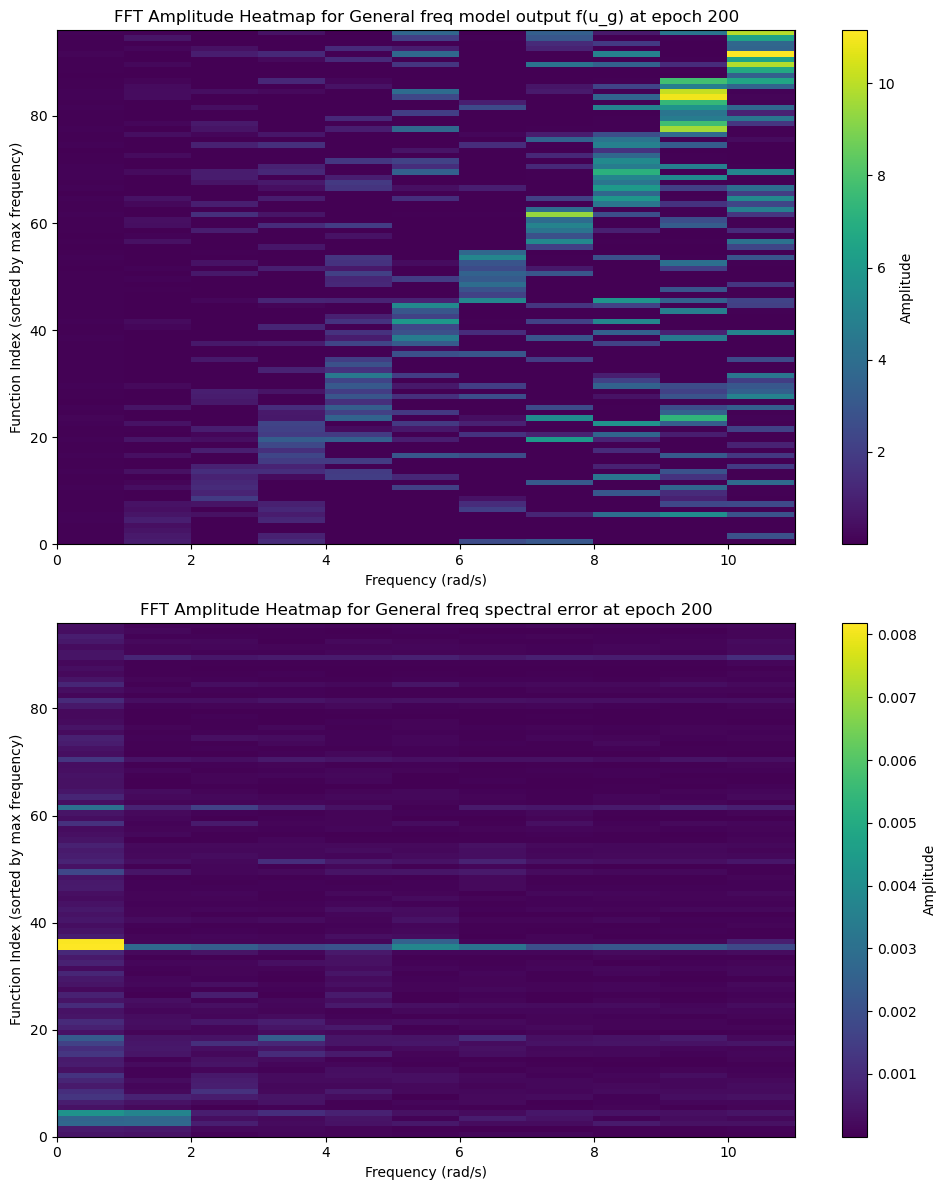

Epoch [202/500], Train Loss: 0.0981, Test Loss: 0.1152
Epoch [203/500], Train Loss: 0.0962, Test Loss: 0.1141
Epoch [204/500], Train Loss: 0.0968, Test Loss: 0.1248
Epoch [205/500], Train Loss: 0.1052, Test Loss: 0.1262
Epoch [206/500], Train Loss: 0.1067, Test Loss: 0.1147
Epoch [207/500], Train Loss: 0.1122, Test Loss: 0.1297
Epoch [208/500], Train Loss: 0.1070, Test Loss: 0.1235
Epoch [209/500], Train Loss: 0.1611, Test Loss: 0.1870
Epoch [210/500], Train Loss: 0.1290, Test Loss: 0.1380
Epoch [211/500], Train Loss: 0.1042, Test Loss: 0.1314
Epoch [212/500], Train Loss: 0.1017, Test Loss: 0.1104
Epoch [213/500], Train Loss: 0.0925, Test Loss: 0.1149
Epoch [214/500], Train Loss: 0.0927, Test Loss: 0.1084
Epoch [215/500], Train Loss: 0.0909, Test Loss: 0.1073
Epoch [216/500], Train Loss: 0.0945, Test Loss: 0.1122
Epoch [217/500], Train Loss: 0.0925, Test Loss: 0.1090
Epoch [218/500], Train Loss: 0.0909, Test Loss: 0.1055
Epoch [219/500], Train Loss: 0.1034, Test Loss: 0.1278
Epoch [220

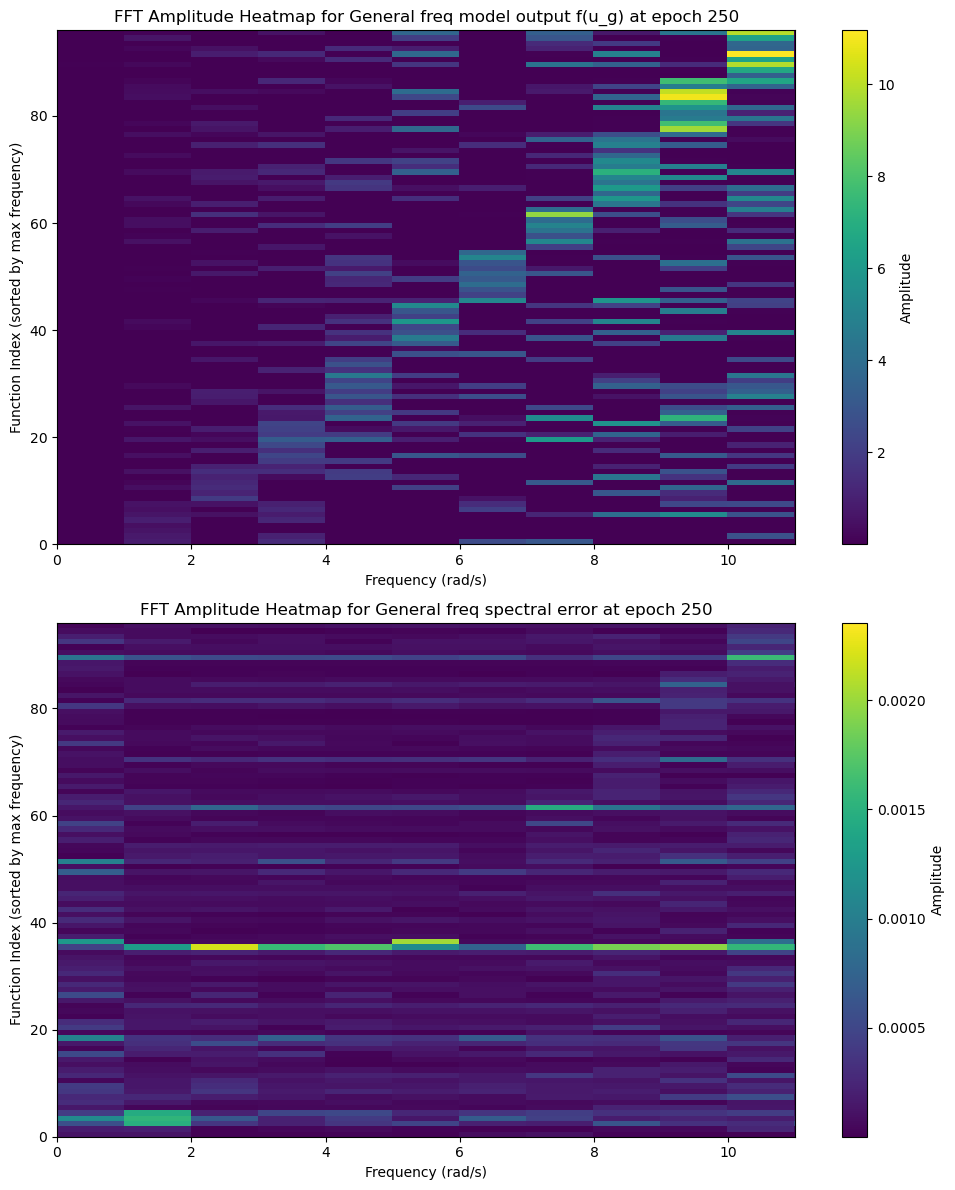

Epoch [252/500], Train Loss: 0.0758, Test Loss: 0.0910
Epoch [253/500], Train Loss: 0.0758, Test Loss: 0.0911
Epoch [254/500], Train Loss: 0.0795, Test Loss: 0.1033
Epoch [255/500], Train Loss: 0.0949, Test Loss: 0.1272
Epoch [256/500], Train Loss: 0.1045, Test Loss: 0.0974
Epoch [257/500], Train Loss: 0.1269, Test Loss: 0.0982
Epoch [258/500], Train Loss: 0.1005, Test Loss: 0.0905
Epoch [259/500], Train Loss: 0.0817, Test Loss: 0.0903
Epoch [260/500], Train Loss: 0.0793, Test Loss: 0.0884
Epoch [261/500], Train Loss: 0.0755, Test Loss: 0.0878
Epoch [262/500], Train Loss: 0.0799, Test Loss: 0.1045
Epoch [263/500], Train Loss: 0.0944, Test Loss: 0.0913
Epoch [264/500], Train Loss: 0.0753, Test Loss: 0.0917
Epoch [265/500], Train Loss: 0.0803, Test Loss: 0.0908
Epoch [266/500], Train Loss: 0.0730, Test Loss: 0.0865
Epoch [267/500], Train Loss: 0.0742, Test Loss: 0.0940
Epoch [268/500], Train Loss: 0.0802, Test Loss: 0.1065
Epoch [269/500], Train Loss: 0.0801, Test Loss: 0.0969
Epoch [270

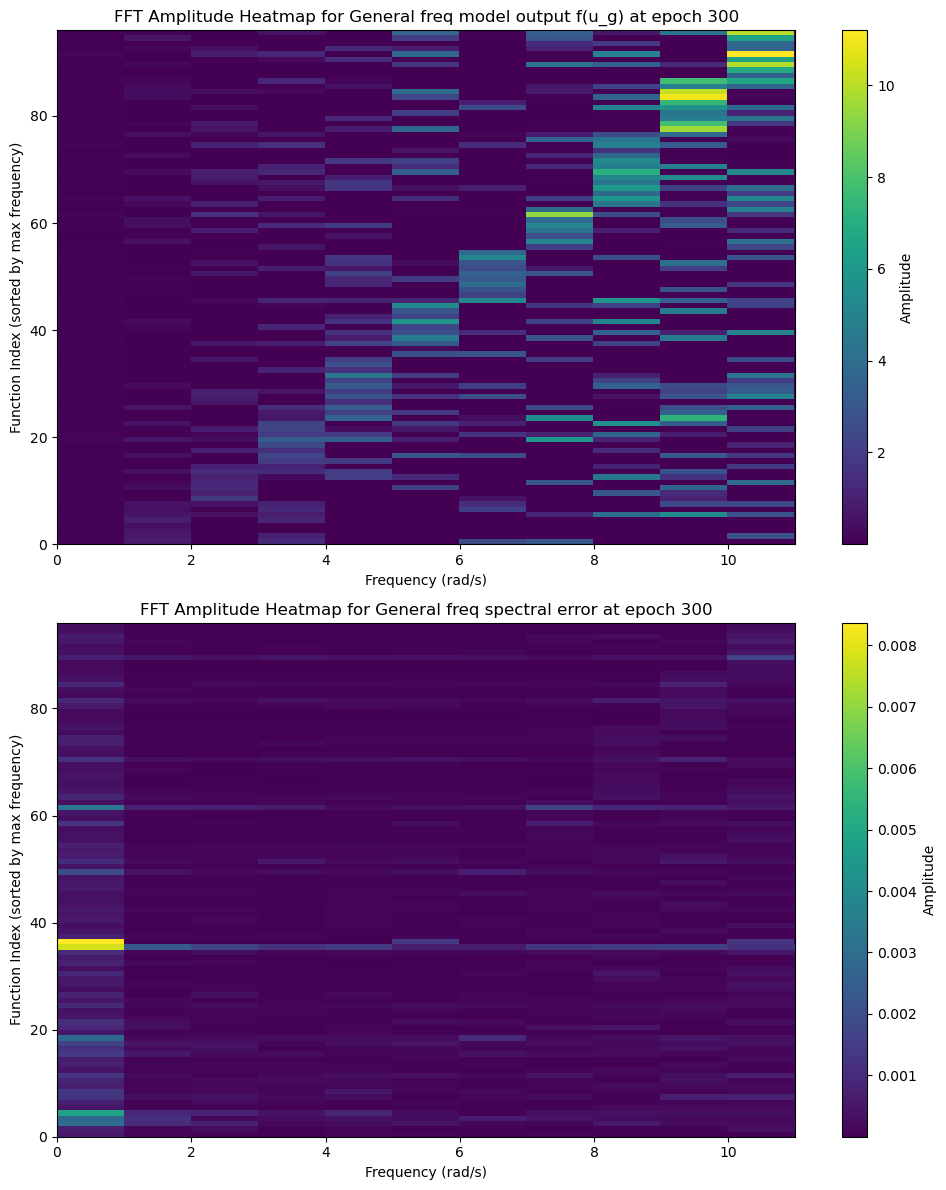

Epoch [302/500], Train Loss: 0.0720, Test Loss: 0.0953
Epoch [303/500], Train Loss: 0.0929, Test Loss: 0.0766
Epoch [304/500], Train Loss: 0.0647, Test Loss: 0.0754
Epoch [305/500], Train Loss: 0.0605, Test Loss: 0.0767
Epoch [306/500], Train Loss: 0.0594, Test Loss: 0.0757
Epoch [307/500], Train Loss: 0.0729, Test Loss: 0.0812
Epoch [308/500], Train Loss: 0.0779, Test Loss: 0.0739
Epoch [309/500], Train Loss: 0.0647, Test Loss: 0.0742
Epoch [310/500], Train Loss: 0.0661, Test Loss: 0.0740
Epoch [311/500], Train Loss: 0.0764, Test Loss: 0.0877
Epoch [312/500], Train Loss: 0.0650, Test Loss: 0.0905
Epoch [313/500], Train Loss: 0.0645, Test Loss: 0.0769
Epoch [314/500], Train Loss: 0.0675, Test Loss: 0.0844
Epoch [315/500], Train Loss: 0.0646, Test Loss: 0.0889
Epoch [316/500], Train Loss: 0.0708, Test Loss: 0.0881
Epoch [317/500], Train Loss: 0.0657, Test Loss: 0.0763
Epoch [318/500], Train Loss: 0.0597, Test Loss: 0.0719
Epoch [319/500], Train Loss: 0.0580, Test Loss: 0.0769
Epoch [320

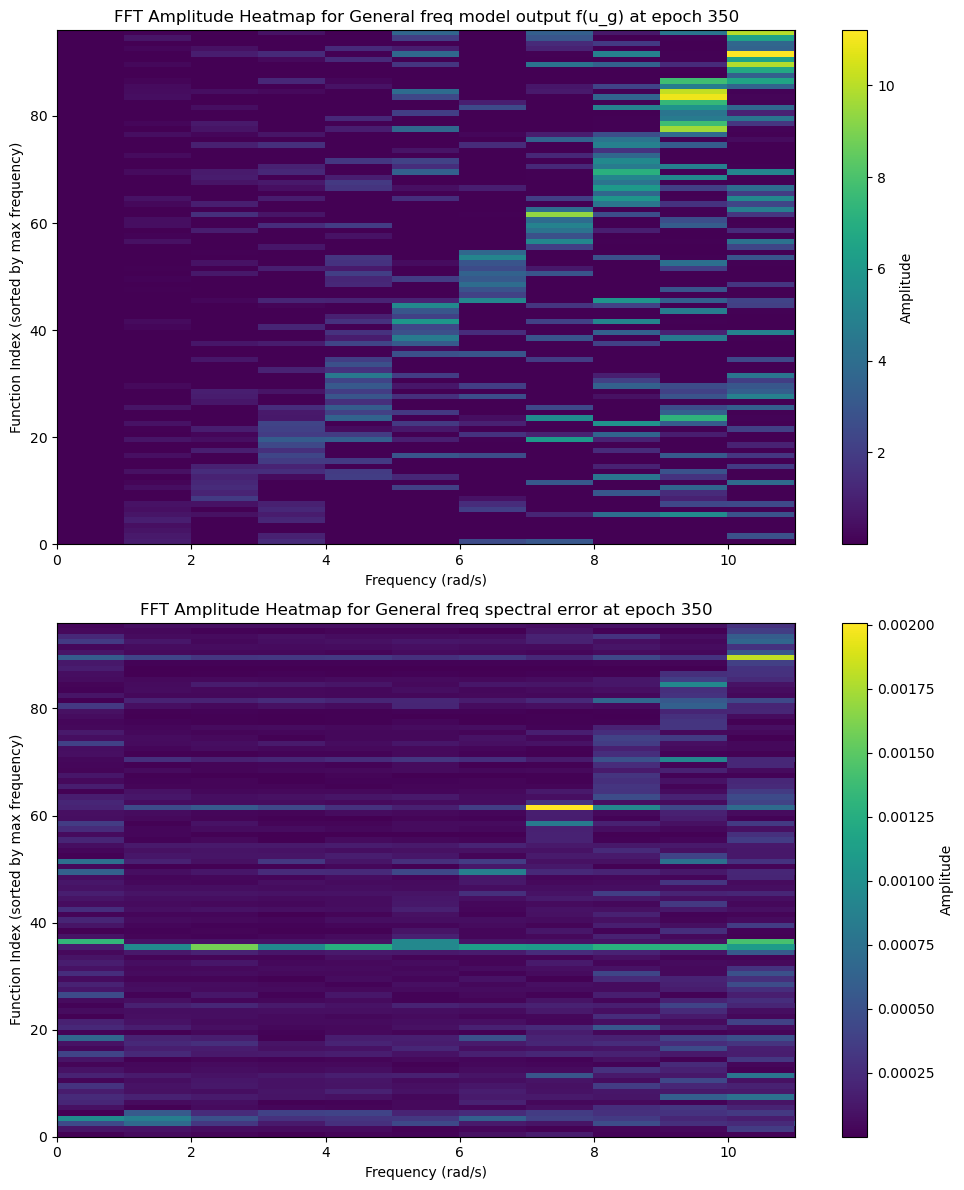

Epoch [352/500], Train Loss: 0.0626, Test Loss: 0.1202
Epoch [353/500], Train Loss: 0.0624, Test Loss: 0.0736
Epoch [354/500], Train Loss: 0.0519, Test Loss: 0.0654
Epoch [355/500], Train Loss: 0.0618, Test Loss: 0.0793
Epoch [356/500], Train Loss: 0.0524, Test Loss: 0.0662
Epoch [357/500], Train Loss: 0.0522, Test Loss: 0.0638
Epoch [358/500], Train Loss: 0.0518, Test Loss: 0.0661
Epoch [359/500], Train Loss: 0.0513, Test Loss: 0.0688
Epoch [360/500], Train Loss: 0.0525, Test Loss: 0.0672
Epoch [361/500], Train Loss: 0.0520, Test Loss: 0.0665
Epoch [362/500], Train Loss: 0.0607, Test Loss: 0.0625
Epoch [363/500], Train Loss: 0.0598, Test Loss: 0.1114
Epoch [364/500], Train Loss: 0.0806, Test Loss: 0.0784
Epoch [365/500], Train Loss: 0.0808, Test Loss: 0.0650
Epoch [366/500], Train Loss: 0.0598, Test Loss: 0.0763
Epoch [367/500], Train Loss: 0.0701, Test Loss: 0.0732
Epoch [368/500], Train Loss: 0.0580, Test Loss: 0.0682
Epoch [369/500], Train Loss: 0.0540, Test Loss: 0.0631
Epoch [370

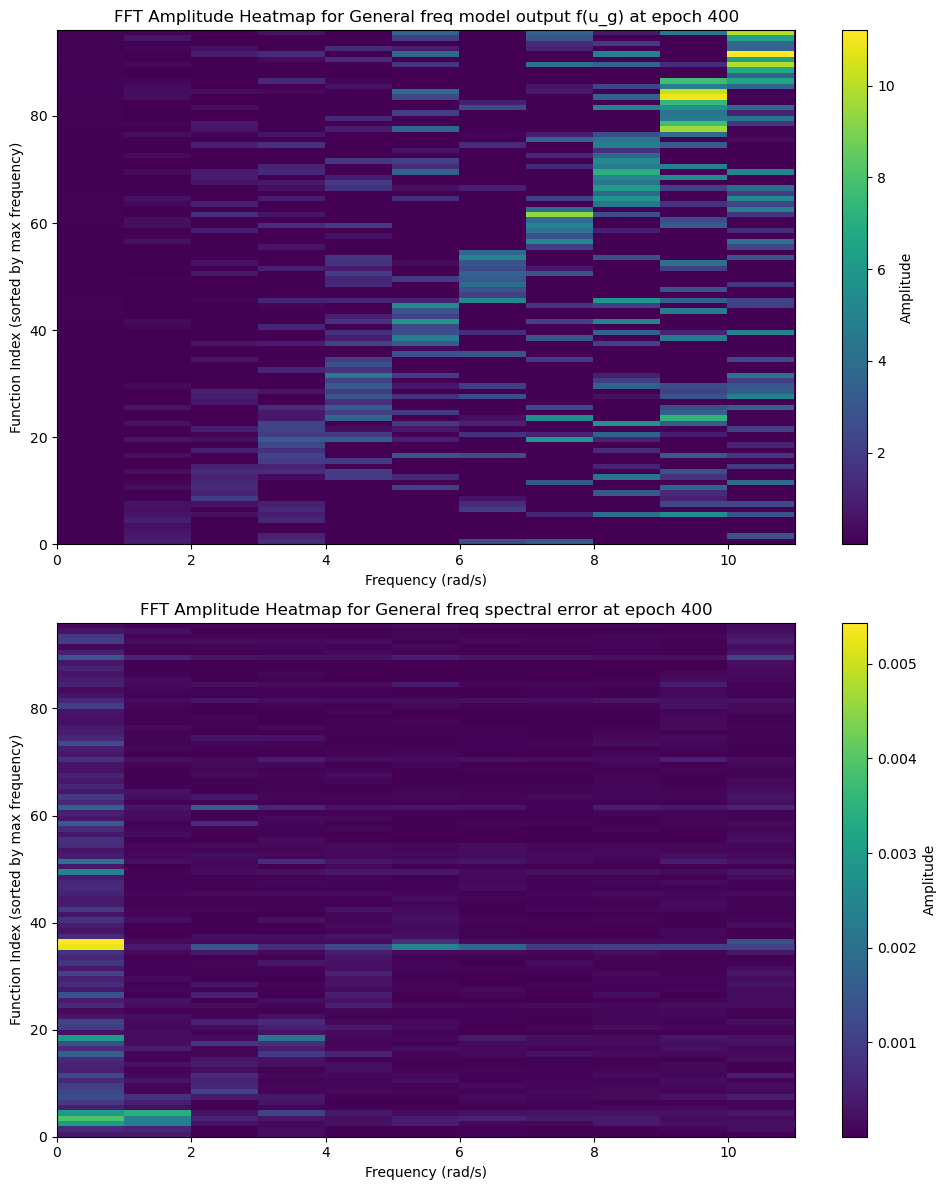

Epoch [402/500], Train Loss: 0.0491, Test Loss: 0.0944
Epoch [403/500], Train Loss: 0.0566, Test Loss: 0.0550
Epoch [404/500], Train Loss: 0.0478, Test Loss: 0.0605
Epoch [405/500], Train Loss: 0.0504, Test Loss: 0.0600
Epoch [406/500], Train Loss: 0.0465, Test Loss: 0.0609
Epoch [407/500], Train Loss: 0.0473, Test Loss: 0.0695
Epoch [408/500], Train Loss: 0.0541, Test Loss: 0.0550
Epoch [409/500], Train Loss: 0.0425, Test Loss: 0.0685
Epoch [410/500], Train Loss: 0.0607, Test Loss: 0.0601
Epoch [411/500], Train Loss: 0.0622, Test Loss: 0.0757
Epoch [412/500], Train Loss: 0.0662, Test Loss: 0.0539
Epoch [413/500], Train Loss: 0.0519, Test Loss: 0.0597
Epoch [414/500], Train Loss: 0.0517, Test Loss: 0.0549
Epoch [415/500], Train Loss: 0.0511, Test Loss: 0.0768
Epoch [416/500], Train Loss: 0.0472, Test Loss: 0.0752
Epoch [417/500], Train Loss: 0.0459, Test Loss: 0.0539
Epoch [418/500], Train Loss: 0.0425, Test Loss: 0.0559
Epoch [419/500], Train Loss: 0.0512, Test Loss: 0.0706
Epoch [420

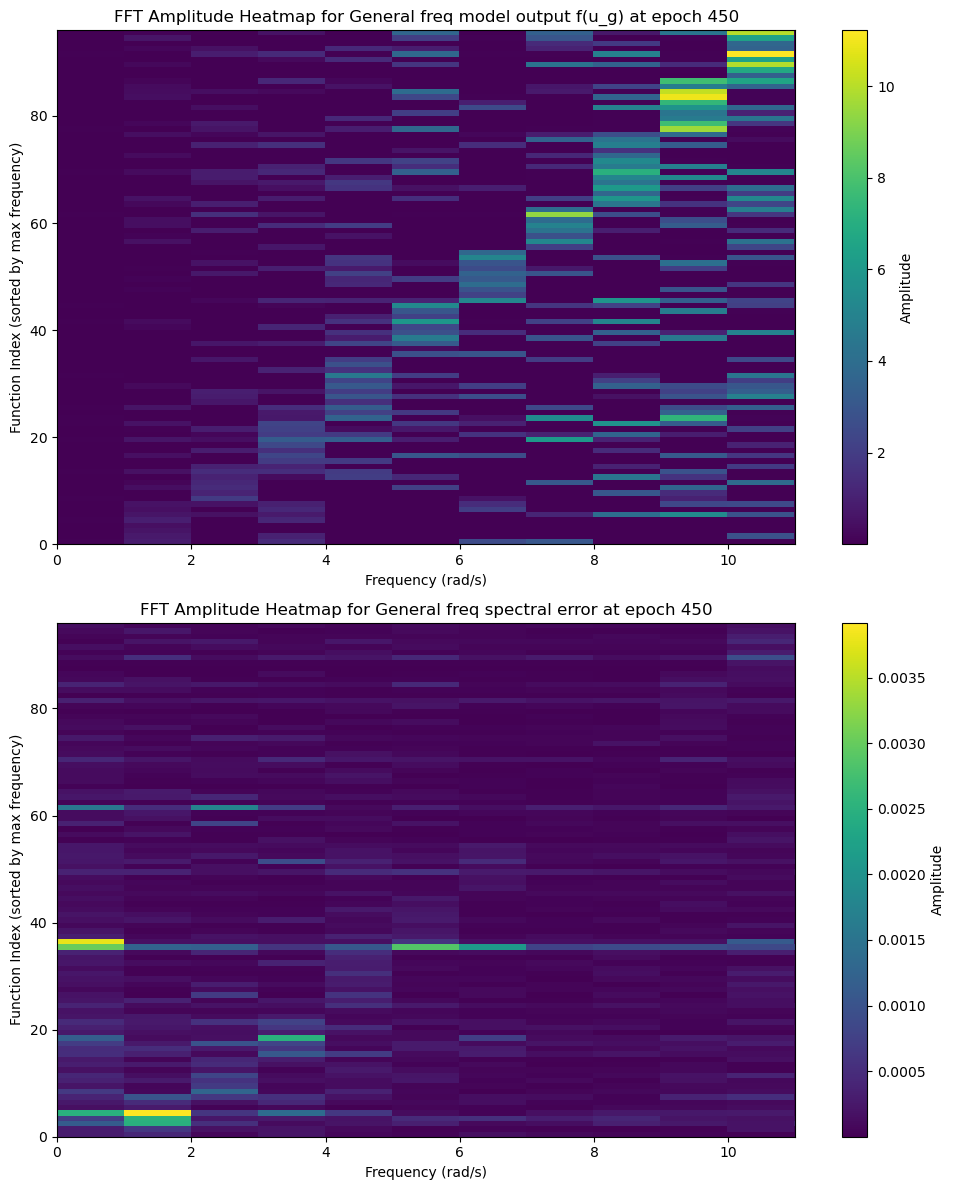

Epoch [452/500], Train Loss: 0.0434, Test Loss: 0.0567
Epoch [453/500], Train Loss: 0.0419, Test Loss: 0.0533
Epoch [454/500], Train Loss: 0.0415, Test Loss: 0.0500
Epoch [455/500], Train Loss: 0.0413, Test Loss: 0.0565
Epoch [456/500], Train Loss: 0.0730, Test Loss: 0.0889
Epoch [457/500], Train Loss: 0.0778, Test Loss: 0.0721
Epoch [458/500], Train Loss: 0.0459, Test Loss: 0.0477
Epoch [459/500], Train Loss: 0.0422, Test Loss: 0.0504
Epoch [460/500], Train Loss: 0.0388, Test Loss: 0.0493
Epoch [461/500], Train Loss: 0.0446, Test Loss: 0.0546
Epoch [462/500], Train Loss: 0.0467, Test Loss: 0.0507
Epoch [463/500], Train Loss: 0.0388, Test Loss: 0.0478
Epoch [464/500], Train Loss: 0.0437, Test Loss: 0.0568
Epoch [465/500], Train Loss: 0.0432, Test Loss: 0.0579
Epoch [466/500], Train Loss: 0.0446, Test Loss: 0.0741
Epoch [467/500], Train Loss: 0.0563, Test Loss: 0.0470
Epoch [468/500], Train Loss: 0.0419, Test Loss: 0.0468
Epoch [469/500], Train Loss: 0.0390, Test Loss: 0.0491
Epoch [470

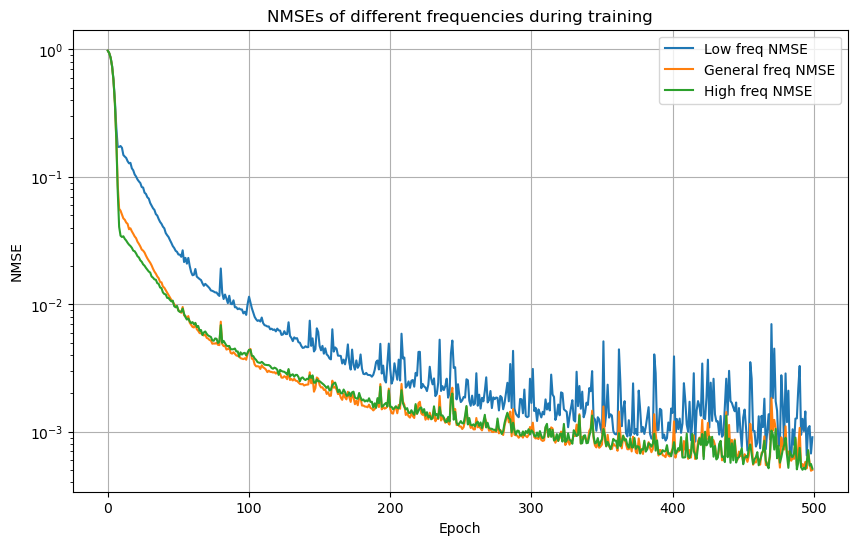

<Figure size 640x480 with 0 Axes>

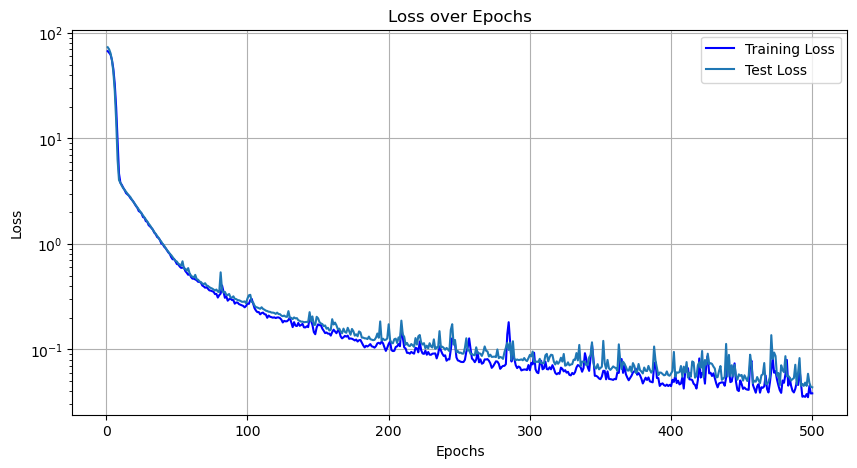

In [219]:
set_seed(seed)
L3ModelK3_low = SimpleCNN(n_layers=3, kernel_size=3)
residue_type = 'error of fourier'

train_losses, test_losses, *_ = model_training_plots(L3ModelK3_low, train_dataloader_g, test_dataloader_g,\
    num_epochs=500, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first', residue=residue_type, lr=1e-3, nmse=False)
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

In [220]:
def train_multiple_runs(train_dataloader, test_dataloader, num_epochs, random_seeds, **kwargs):
    overall_low_freq_nmses = []
    overall_general_freq_nmses = []
    overall_high_freq_nmses = []
    
    for seed in random_seeds:
        torch.manual_seed(seed)
        np.random.seed(seed)

        set_seed(seed)
        model = SimpleCNN(n_layers=3, kernel_size=3)

        
        train_losses, test_losses, low_freq_nmses, general_freq_nmses, high_freq_nmses, epoch_list = model_training_plots(
            model, train_dataloader, test_dataloader, num_epochs, **kwargs
        )
        
        overall_low_freq_nmses.append(low_freq_nmses)
        overall_general_freq_nmses.append(general_freq_nmses)
        overall_high_freq_nmses.append(high_freq_nmses)
    
    return overall_low_freq_nmses, overall_general_freq_nmses, overall_high_freq_nmses, epoch_list

In [221]:
def plot_results_with_error_bars(overall_low_freq_nmses, overall_general_freq_nmses,\
    overall_high_freq_nmses, epoch_list, fig_path):
    plt.figure(figsize=(10, 6))
    
    for data, label in zip([overall_low_freq_nmses, overall_general_freq_nmses, overall_high_freq_nmses], 
                           ['Low freq NMSE', 'General freq NMSE', 'High freq NMSE']):
        mean_losses = np.mean(data, axis=0)
        std_losses = np.std(data, axis=0)
        
        plt.plot(epoch_list, mean_losses, label=f'Mean {label}')
        plt.fill_between(epoch_list, mean_losses - std_losses, mean_losses + std_losses, alpha=0.2)

    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.yscale('log')
    plt.title('Mean NMSEs of different frequencies during training (with std dev)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.savefig(fig_path)
    

20
Plotting ground truth u_g
Plotting ground truth u_g
Plotting ground truth u_g
Plotting ground truth u_g
Plotting ground truth u_g
Plotting ground truth u_g
Sorting u_g for the first time
Epoch [1/20], Train Loss: 67.4027, Test Loss: 72.7054
Plotting the colormap once at iteration 0
Plotting model output f(u_g)
Plotting model output f(u_g)
Plotting model output f(u_g)
Using predefined sort


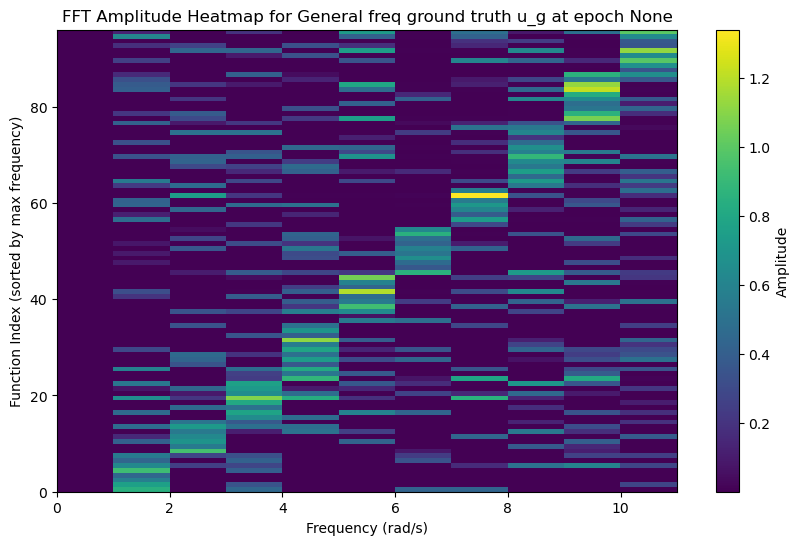

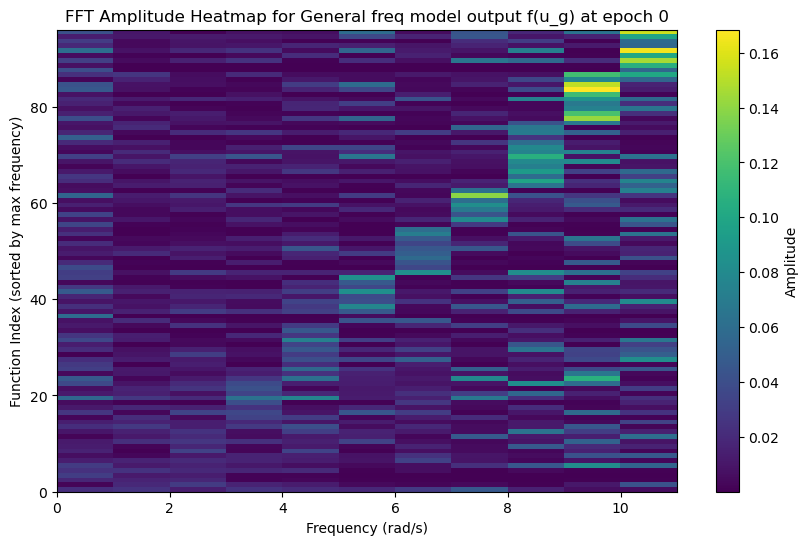

Epoch [2/20], Train Loss: 64.2363, Test Loss: 68.5908
Epoch [3/20], Train Loss: 59.6274, Test Loss: 61.3982
Epoch [4/20], Train Loss: 52.0043, Test Loss: 50.2519
Epoch [5/20], Train Loss: 39.3498, Test Loss: 35.9186
Epoch [6/20], Train Loss: 26.4023, Test Loss: 20.4582
Epoch [7/20], Train Loss: 13.5229, Test Loss: 8.8509
Epoch [8/20], Train Loss: 5.7602, Test Loss: 3.9919
Epoch [9/20], Train Loss: 3.6152, Test Loss: 3.5826
Epoch [10/20], Train Loss: 3.2777, Test Loss: 3.3260
Epoch [11/20], Train Loss: 3.1564, Test Loss: 3.0954
Epoch [12/20], Train Loss: 2.9200, Test Loss: 2.9423
Epoch [13/20], Train Loss: 2.7109, Test Loss: 2.7817
Epoch [14/20], Train Loss: 2.6451, Test Loss: 2.6457
Epoch [15/20], Train Loss: 2.5390, Test Loss: 2.5313
Epoch [16/20], Train Loss: 2.3956, Test Loss: 2.4292
Epoch [17/20], Train Loss: 2.2570, Test Loss: 2.3158
Epoch [18/20], Train Loss: 2.2242, Test Loss: 2.2167
Epoch [19/20], Train Loss: 2.1197, Test Loss: 2.1195
Epoch [20/20], Train Loss: 2.0324, Test Los

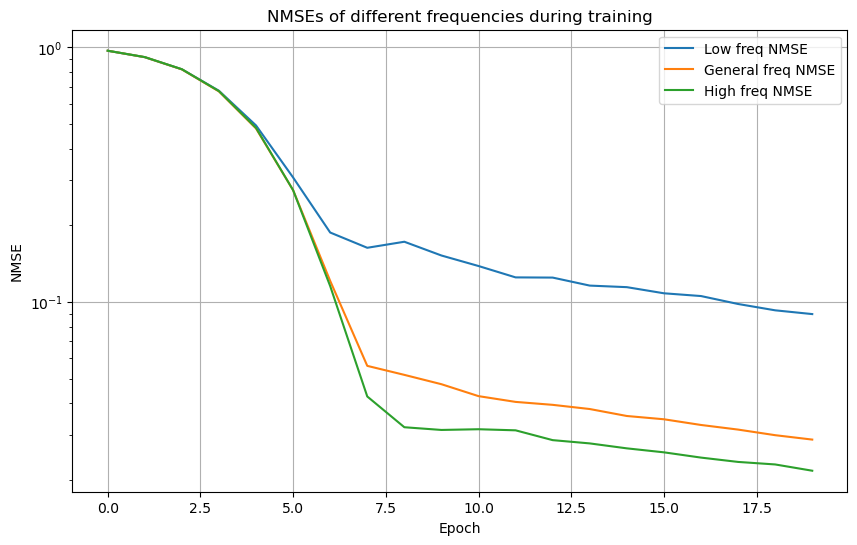

20
Plotting ground truth u_g
Plotting ground truth u_g
Plotting ground truth u_g
Plotting ground truth u_g
Plotting ground truth u_g
Plotting ground truth u_g
Sorting u_g for the first time
Epoch [1/20], Train Loss: 66.0704, Test Loss: 73.0256
Plotting the colormap once at iteration 0
Plotting model output f(u_g)
Plotting model output f(u_g)
Plotting model output f(u_g)
Using predefined sort


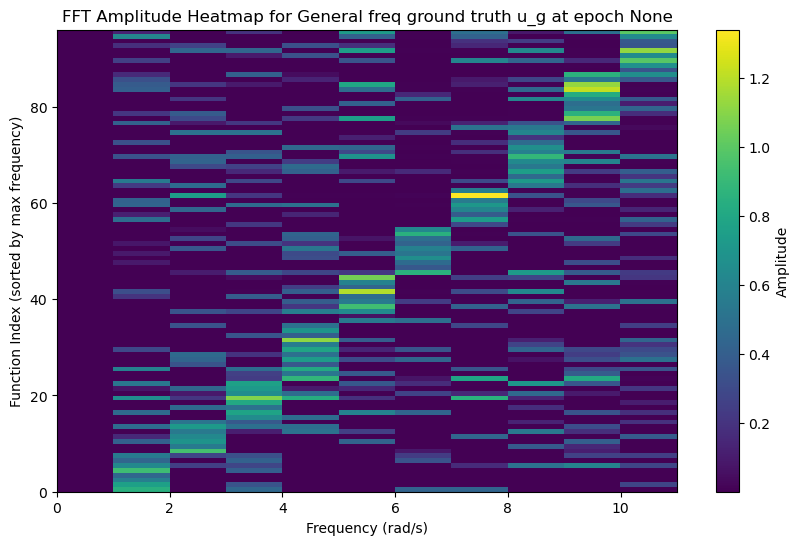

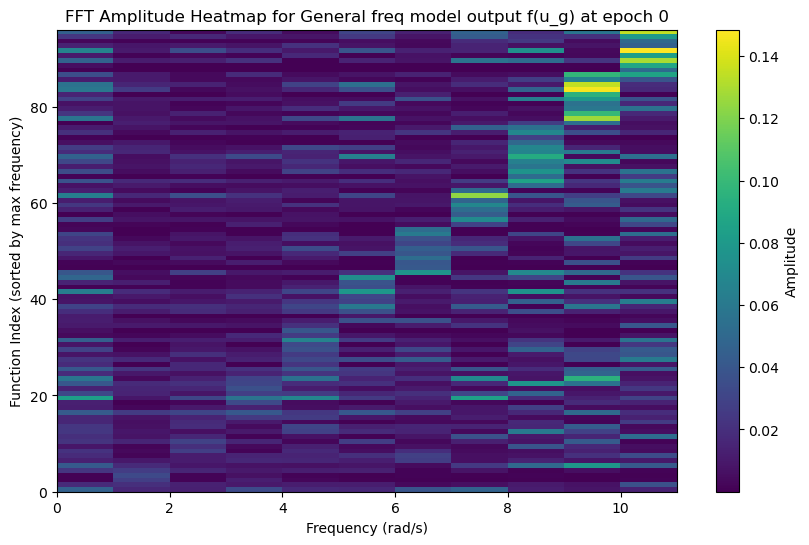

Epoch [2/20], Train Loss: 64.7387, Test Loss: 69.2141
Epoch [3/20], Train Loss: 59.8297, Test Loss: 62.0031
Epoch [4/20], Train Loss: 52.4600, Test Loss: 50.4329
Epoch [5/20], Train Loss: 39.3893, Test Loss: 35.1086
Epoch [6/20], Train Loss: 25.2326, Test Loss: 18.8118
Epoch [7/20], Train Loss: 11.8105, Test Loss: 7.2035
Epoch [8/20], Train Loss: 4.4874, Test Loss: 3.1986
Epoch [9/20], Train Loss: 2.9266, Test Loss: 3.0153
Epoch [10/20], Train Loss: 2.6999, Test Loss: 2.8043
Epoch [11/20], Train Loss: 2.5427, Test Loss: 2.5949
Epoch [12/20], Train Loss: 2.4119, Test Loss: 2.5393
Epoch [13/20], Train Loss: 2.3622, Test Loss: 2.4300
Epoch [14/20], Train Loss: 2.2830, Test Loss: 2.3505
Epoch [15/20], Train Loss: 2.2015, Test Loss: 2.2639
Epoch [16/20], Train Loss: 2.1563, Test Loss: 2.1863
Epoch [17/20], Train Loss: 2.0515, Test Loss: 2.1150
Epoch [18/20], Train Loss: 1.9945, Test Loss: 2.0482
Epoch [19/20], Train Loss: 1.9325, Test Loss: 1.9844
Epoch [20/20], Train Loss: 1.8588, Test Los

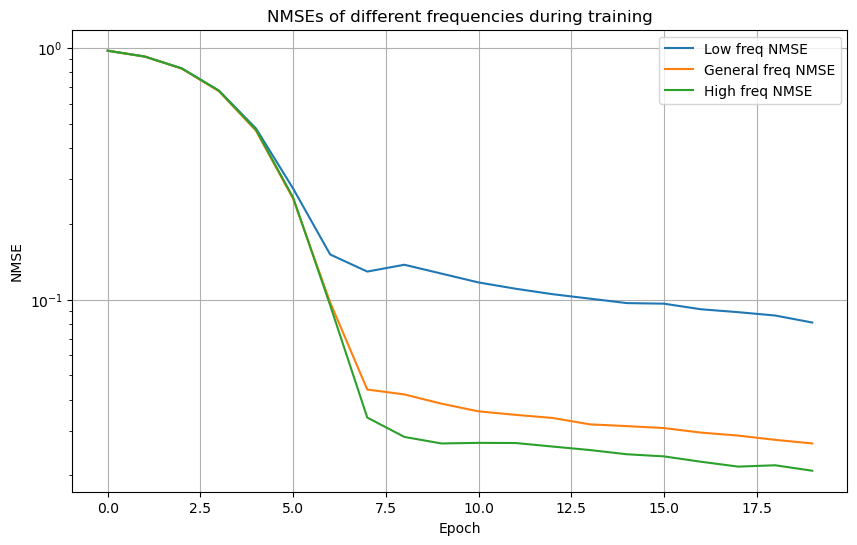

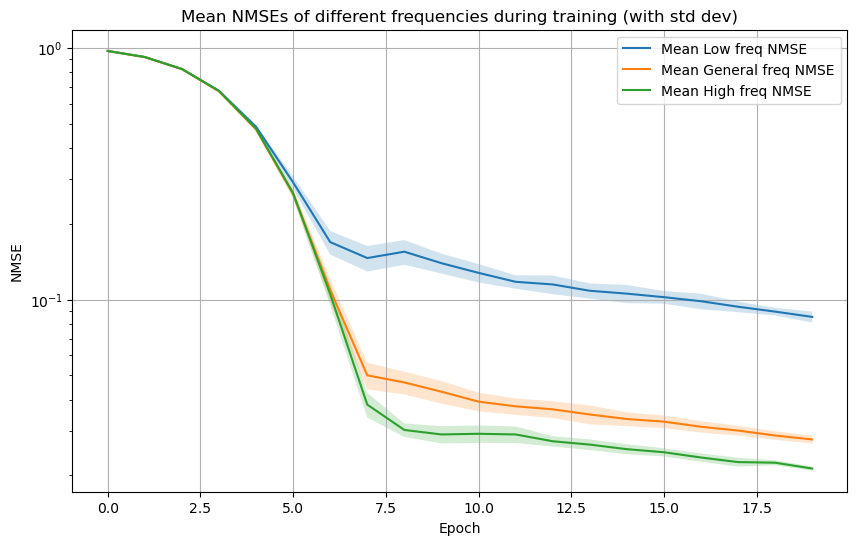

FileNotFoundError: [Errno 2] No such file or directory: '/home/users/erikwang/multistage/plots/spectral_bias/L3K3_MSE_runs.png'

<Figure size 640x480 with 0 Axes>

In [222]:
# random_seeds = [1, 2, 3, 4, 5]
random_seeds = [1, 2]
num_epochs = 20

overall_low_freq_nmses, overall_general_freq_nmses, overall_high_freq_nmses,\
    epoch_list = train_multiple_runs(train_dataloader_g, test_dataloader_g, num_epochs, random_seeds)

# Plot the results
plot_results_with_error_bars(overall_low_freq_nmses, overall_general_freq_nmses,\
    overall_high_freq_nmses, epoch_list, fig_path='/home/users/erikwang/multistage/plots/spectral_bias/L3K3_MSE_runs.png')